# Decision Trees and Random Forests: Application on feature data for K562 cell line in GREG.

### Author : Shaurya Jauhari (Email: shauryajauhari@gzhmu.edu.cn)
### Last Reviewed : December 15th 2020

## Background

This notebook assesses variaegated implementations of the random forest models for the data dervied from the K562 cell-line in GREG. The data for the same and other cell-types for GREG is available at this <a href = "https://zenodo.org/deposit/4265559"> link</a>.

## Contents

* [1. Decision Trees](#link1)
    * [1.1 Package Installation and Loading Libraries](#link2)
    * [1.2 Dataset Handling](#link3)
    * [1.3 Deploying Tree Models](#link4)
        * [1.3.1 'party' Package](#link5)
            * [1.3.1.1 SMOTE Transformation](#link6)
        * [1.3.2 'rpart' Package](#link7)
* [2. Random Forests](#link8)
    * [2.1  Core (randomForest)](#link9)
* [3. Visualizing Predictions](#link10)
* [4. Session Information](#link11)

##  <a id=link1>1. Decision Trees </a>

### <a id=link2>1.1 Package Installation and Loading Libraries </a>

In [1]:
requiredPackages <- c("party", "rpart", "rpart.plot", "ROSE", "DMwR", "randomForest")
newPackages <- requiredPackages[!(requiredPackages %in% installed.packages()[,"Package"])]
if(length(newPackages)) install.packages(newPackages,
                                         repos = "https://mirrors.tuna.tsinghua.edu.cn/CRAN/",
                                         dependencies = TRUE)

suppressPackageStartupMessages(library(party))
suppressPackageStartupMessages(library(rpart))
suppressPackageStartupMessages(library(rpart.plot))
suppressPackageStartupMessages(library(DMwR))
suppressPackageStartupMessages(library(randomForest))
suppressPackageStartupMessages(library(ROSE))
suppressPackageStartupMessages(library(ggplot2))

### <a id=link3>1.2 Dataset Handling </a>

In [2]:
k562gregStandard <- read.table("../../transcriptionFactoriesGREG/MachineLearning/data/K562forML.txt", header = TRUE) ## loading data
k562greg <- k562gregStandard[, -c(1:3)] ## removing the first three columns for non-usage in the ML model.

In [3]:
head(k562greg)

,CTCF,EP300,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H3K9me3,RAD21,RNA.Seq,RNAPol2,RNAPol3,YY1,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,0.00000,0.0000000,0.0000000,0.000000,0.0000000,0.000000,0.000000,0.000000,0.00000,0.000000,0,0.0000000,0.00000,0.0000000,Non-Hub
2,0.00000,0.0000000,0.0000000,0.000000,0.0000000,0.000000,0.000000,0.000000,0.00000,0.000000,0,0.0000000,0.00000,0.0000000,Non-Hub
3,0.00000,0.0000000,0.0000000,0.000000,0.0000000,0.000000,0.000000,0.000000,0.00000,0.000000,0,0.0000000,0.00000,0.0000000,Non-Hub
4,0.00000,0.0000000,0.0000000,0.000000,0.0000000,0.000000,0.000000,0.000000,0.00000,0.000000,0,0.0000000,0.00000,0.0000000,Non-Hub
5,0.00000,0.0000000,0.0000000,0.000000,0.0000000,0.000000,0.000000,0.000000,0.00000,0.000000,0,0.0000000,0.00000,0.0000000,Non-Hub
6,47.61676,0.0274939,0.8087214,1.045595,0.7726153,1.202883,1.627348,1.188197,6.28546,8.497575,0,0.1668389,20.66886,0.1562263,Non-Hub


In [4]:
rownames(k562greg) <- c()
k562greg$Class <- as.numeric(as.factor(k562greg$Class))
k562greg$Class <- ifelse(k562greg$Class == 2, 0, 1)
head(k562greg$Class)

[1] 0 0 0 0 0 0

### <a id=link4>1.3 Deploying Tree Models </a>

#### <a id=link5>1.3.1 'party' Package </a>

Let us now partition the data into training and testing subsets, as per the Pareto's dogma, i.e. maintaining 80:20 ratio for train and testing cases.

In [5]:
set.seed(3)
dataPartition <- sample(2, nrow(k562greg), replace = TRUE, prob = c(0.8,0.2))
train <- k562greg[dataPartition==1,]
test <- k562greg[dataPartition==2,]

In [6]:
cat("We have",nrow(train),"training examples and",nrow(test),"for testing.")

We have 1214997 training examples and 304513 for testing.

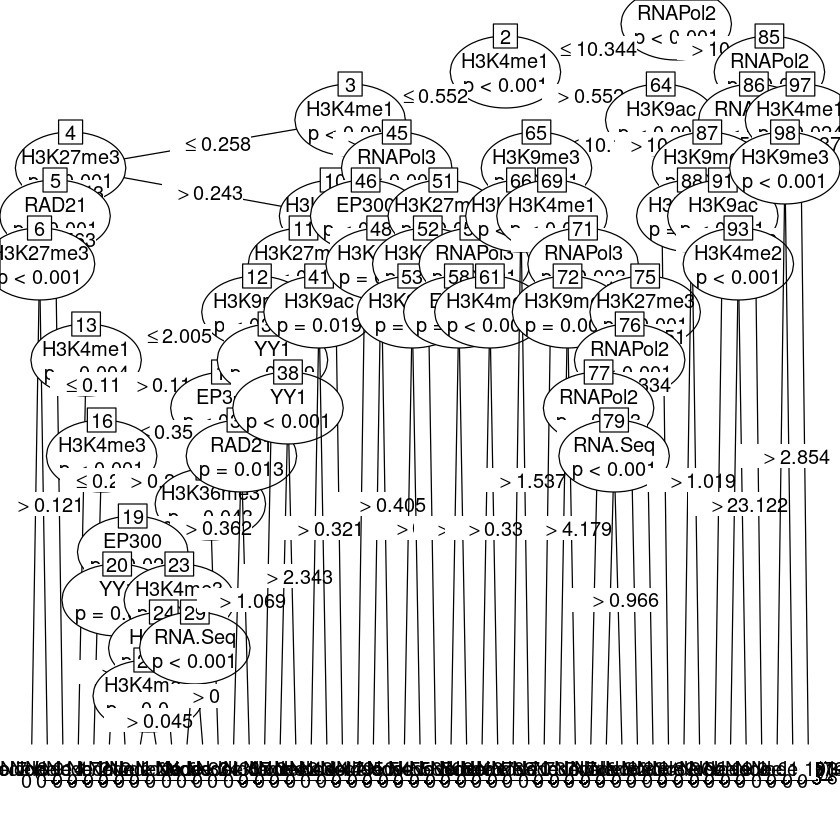

In [7]:
k562Tree <- ctree(Class ~ ., data= train)
plot(k562Tree)

In [8]:
source("../../transcriptionFactoriesGREG/MachineLearning/R/modelPerformance.R")
modelPerformance(k562Tree, "rf", test, Class)

The confusion matrix is
         Actual
Predicted      0      1
        0 303755    758
The accuracy of the model is 99.75108 % 
The misclassification error of the model is 0.248922 % 


[1] "Only a single class predicted. Probably skewed data handling."

In [9]:
treePred <- predict(k562Tree,test)
head(ifelse(treePred > 0.5, "Hub", "Non-Hub"))
treePred <- ifelse(treePred > 0.5, "1", "0")

Class
Non-Hub
Non-Hub
Non-Hub
Non-Hub
Non-Hub
Non-Hub


In [10]:
treePredProb <- predict(k562Tree, test, type="prob")
head(treePredProb)

[[1]]
[1] 0.00022602

[[2]]
[1] 0.0166849

[[3]]
[1] 0.0166849

[[4]]
[1] 0.0166849

[[5]]
[1] 0.006076571

[[6]]
[1] 0.004602902

It can be articulated that the high skewness in data towards "Non-Hubs" outnumbering "Hubs" has engenedered a high-probability of classification for the former and "Hubs" haven't been predicted at all. 

Let us examine if the bifurcation of data into 6:4 ratio of training and testing sets makes any difference in the structure of the classification tree here.

In [11]:
set.seed(03)
dataPartition64 <- sample(2, nrow(k562greg), replace = TRUE, prob = c(0.6,0.4))
train64 <- k562greg[dataPartition64==1,]
test64 <- k562greg[dataPartition64==2,]

In [12]:
cat("We have",nrow(train64),"training examples and",nrow(test64),"for testing.")

We have 911783 training examples and 607727 for testing.

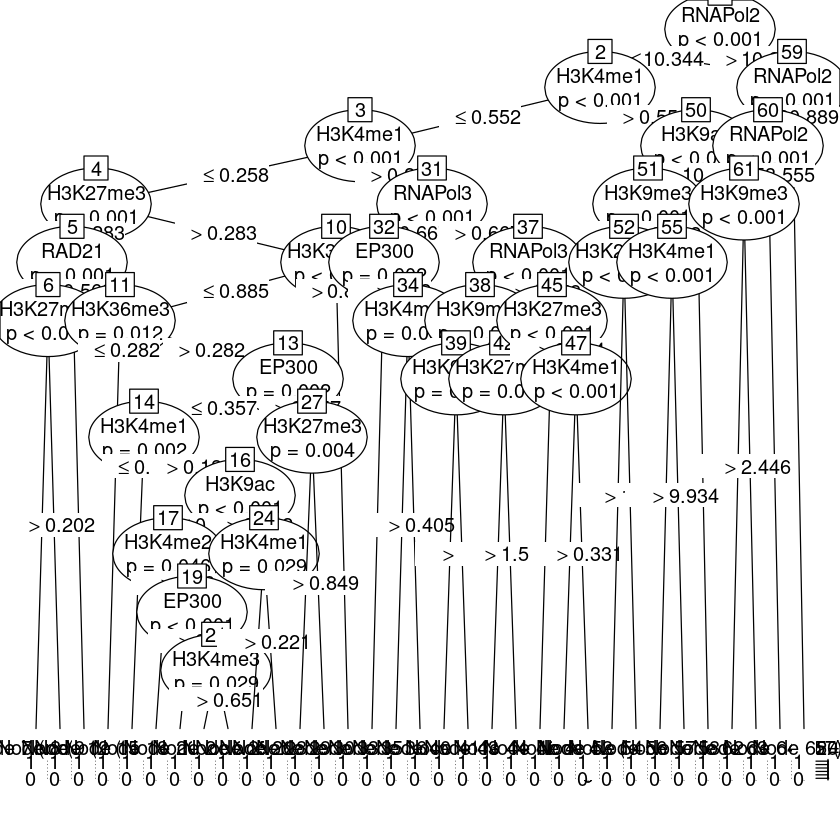

In [13]:
k562Tree64 <- ctree(Class ~ ., data= train64)
plot(k562Tree64)

In [14]:
treePred64 <- predict(k562Tree64, test64, type="response")
treePred64 <- ifelse(treePred64 > 0.5, "1", "0")

In [15]:
modelPerformance(k562Tree64, "rf", test64, Class)

The confusion matrix is
         Actual
Predicted      0      1
        0 606253   1474
The accuracy of the model is 99.75746 % 
The misclassification error of the model is 0.2425431 % 


[1] "Only a single class predicted. Probably skewed data handling."

No luck here too. The data is highly biased, even for the modified data split. Let's resort to SMOTE transformation.

##### <a id=link6>1.3.1.1 SMOTE Transformation </a>

SMOTE transformation of the data has engendered fair model performance, in the case of logistic regression. See the pipeline [here](https://nbviewer.jupyter.org/github/shauryajauhari/transcriptionFactoriesGREG/blob/master/MachineLearning/LogisticRegressionA549GREG.ipynb).

In [16]:
table(train$Class)


      0       1 
1212078    2919 

This clearly shows the under-representation of the positive class ("1") in the data upon which the model is supposed to be built. We need to make an effort to balance the class load.

In [17]:
train$Class <- as.factor(train$Class)
set.seed(77)
smoteData <- SMOTE(Class ~., train, perc.over = 2000, k = 5, perc.under = 105)
table(smoteData$Class)


    0     1 
61299 61299 

Now that the data is seemingly balanced, let's examine the performance of the model.

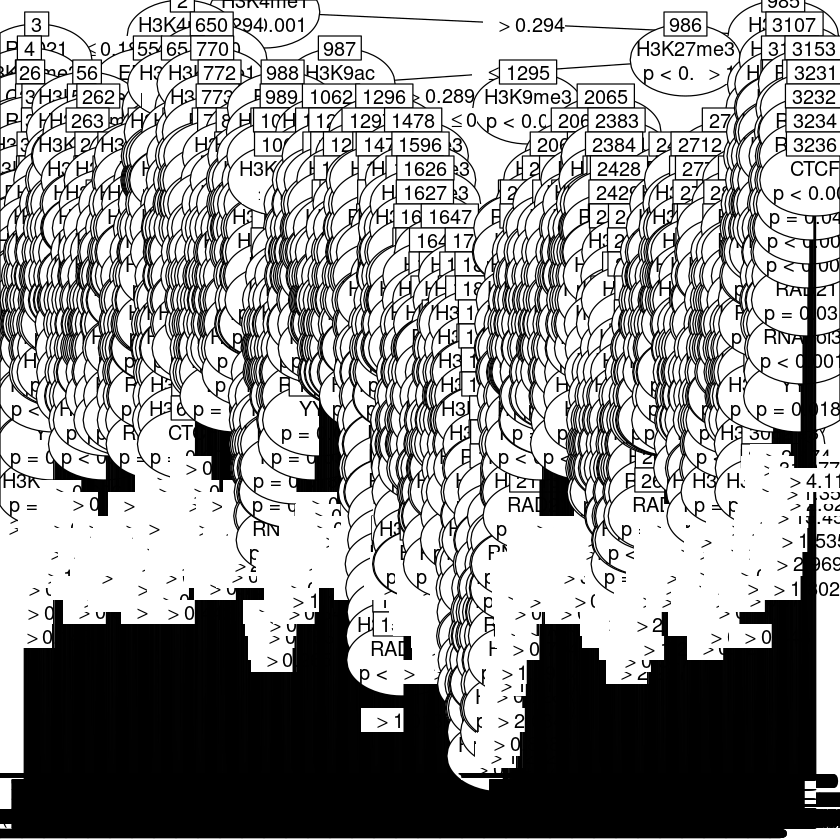

In [18]:
k562SmoteTree <- ctree(Class ~ ., data= smoteData)
plot(k562SmoteTree)

Apparently, the stablization of the class distribution in the data has made the tree more comprehensive. 

Obviously, it is hard to interpret the graphic above.

In [19]:
treeSmotePred <- predict(k562SmoteTree, test)
head(treeSmotePred)

[1] 0 0 1 0 0 0
Levels: 0 1

The confusion matrix is
         Actual
Predicted      0      1
        0 262412    337
        1  41343    421
The accuracy of the model is 86.31257 % 
The misclassification error of the model is 13.68743 % 
The sensitivity of the model is 86.38936 % 
The specificity of the model is 55.5409 % 
The area under curve is 0.7096513 



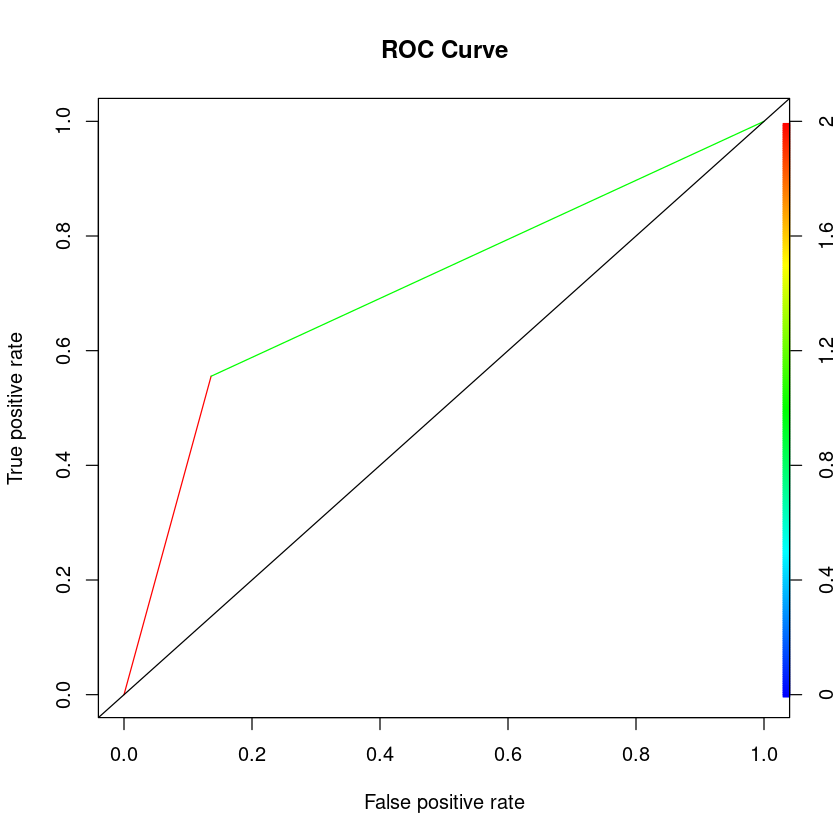

In [20]:
modelPerformance(k562SmoteTree, "rf", test, Class)

We can see distinct class indulgences, as opposed to the above cases of just "Non-Hub" instances.

The AUC and accuracy are pretty darn fair. Also, a notable observation is that the sensitivity and specificity are well balanced. Maybe, we should explore other options.

<p align="justify"> Addtionally, the function ctree() offers flexibility in terms of defining parameters for classification via ctree_control() function. Look for attributes *mincriterion* and *minsplit*. The former denotes the confidence level (i.e. 1- probability value), while the latter signifies the minimum number of samples required for splitting a tree branch into two. The default values are 0.95 and 20 respectively. Let us examine if any alteration makes a difference.They can be accessed via *controls*, i.e. ctree(formula,data,controls=ctree_control(mincriterion= , minsplit= ).</p>

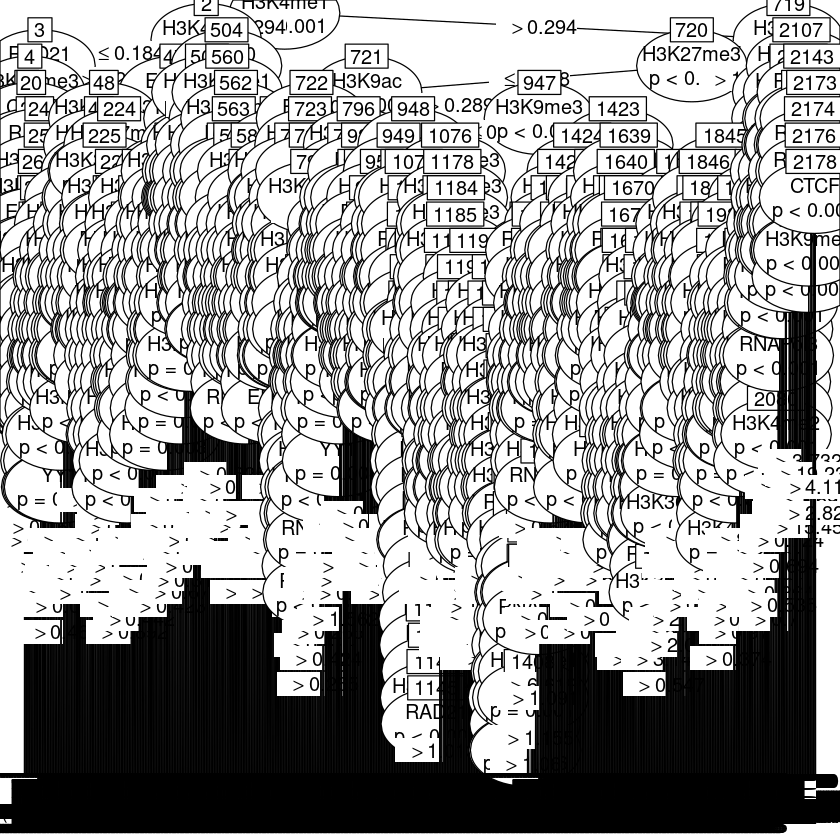

In [21]:
k562SmoteTreeAlt <- ctree(Class ~ ., data= smoteData, controls=ctree_control(mincriterion = .99, minsplit= 10))
plot(k562SmoteTreeAlt)

This tree has relatively lesser number of nodes as more stringent criteria have been imposed. Let us work out the performance metrics for this classification model for the test data.

The confusion matrix is
         Actual
Predicted      0      1
        0 256103    317
        1  47652    441
The accuracy of the model is 84.24731 % 
The misclassification error of the model is 15.75269 % 
The sensitivity of the model is 84.31236 % 
The specificity of the model is 58.17942 % 
The area under curve is 0.7124589 



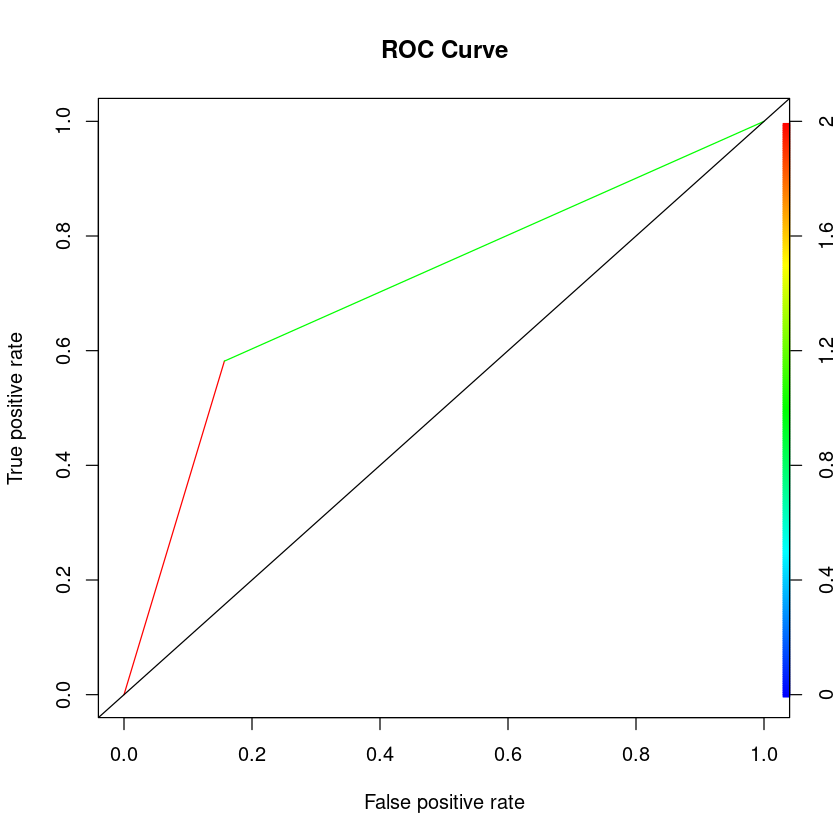

In [22]:
modelPerformance(k562SmoteTreeAlt, "RF", test, Class)

We are assuming "Hub" as a demarcation for the positive class, and so sensitivity of the model being still lower than the specificity establishes that the model is more comprehensible for the "Non-Hub" (negative class). This can again be attributed to the share of data for the respective classes. Ideally, both values be as high in magnitude, is reminiscent of a good model.  

#### <a id=link7>1.3.2 'rpart' Package </a>

Using another package, we shall continue to work on the SMOTE transformed training data to model the classifier.

In [23]:
k562TreeAlt <- rpart(Class ~ ., data = smoteData)

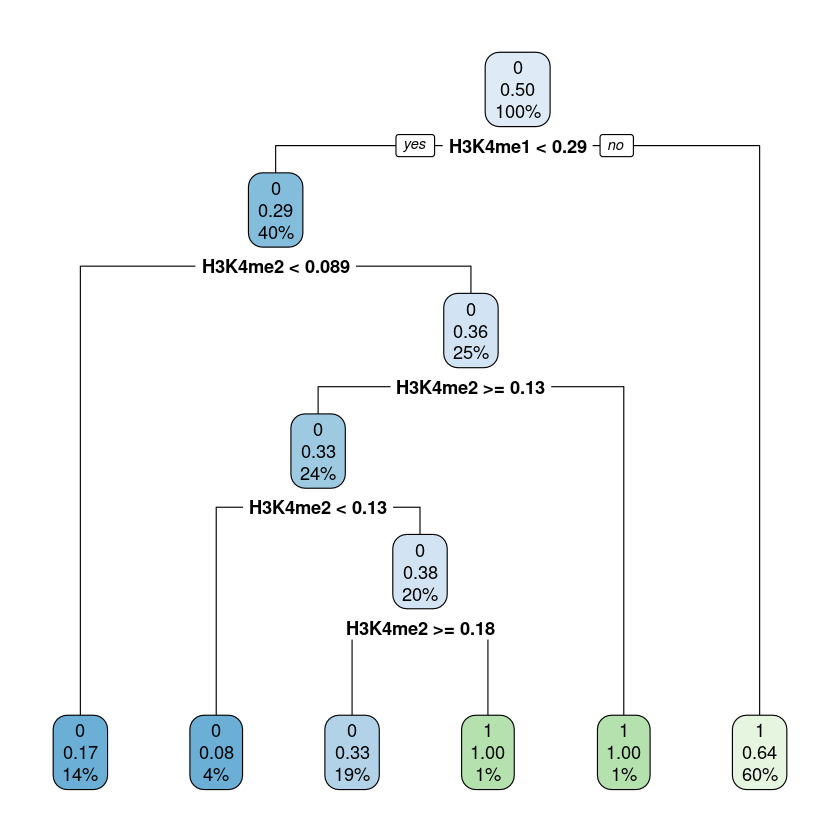

In [24]:
rpart.plot(k562TreeAlt)

There is a complete contrast between the two trees drawn from *ctree()* and *rpart()* functions. The *ctree* uses a significance test procedure in order to select variables instead of selecting the variable that maximizes an information measure (e.g. Gini coefficient). Basically the methodology of both approaches is different; *rpart* is a CART algorithm, while *party* is a CHAID algorithm. (http://www.bzst.com/2006/10/classification-trees-cart-vs-chaid.html).

Next, we move to the more fuller concept, of Random Forests.

##  <a id=link8>2. Random Forests </a>

Decision trees are accomodated inside Random Forests. This ensemble brings about variety in data classification and hence more robustness. This notion also helps in avoidance of overfitting. Random forests can deal with large number of features and selects them for constructing trees on the basis of importance. As we will see, they are easy to implement and have two free parameters to tune- (i) *ntree* signifying the number of trees (where default value is 500), and (ii) *mtry* denoting variables randomly selected for each split (default here sq(p) when classification is sought, and (p/3) when regression; p is the total number of features in the dataset) 

###  <a id=link9>2.1 Core (randomForest) </a>

There are basically three steps involved in construction of a Random Forest:
    1. Draw *ntree* bootstrap samples.
    2. For each bootstrap sample, grow a un-pruned tree by choosing best split based on a random sample of *mtry* predictors at each node.
    3. Predict new data using majority votes for classification, and average for regression based on *ntree* trees.

For application, we shall consider a subset of the data we used for decision trees. The random forests algorithm tend to consume greater in terms of computational resources.

Moving away from the Pareto's principle, let us work with 70:30 split for training and testing data.

In [25]:
## Let us work with a fraction (10%) of data. The algorithm, given the computational resources, fails in execution for the whole data. 

set.seed(8)
k562gregSample <- k562greg[sample(nrow(k562greg), replace=T, size=0.1*nrow(k562greg)),]

## Making thr response variable a 'factor', since we are attempting classification.

k562gregSample$Class <- as.factor(k562gregSample$Class)

## failing to which a warning is thrown : Warning message in randomForest.default(m, y, ...):
## “The response has five or fewer unique values.  Are you sure you want to do regression?”

dataPartition73 <- sample(2, nrow(k562gregSample), replace = TRUE, prob = c(0.7,0.3))

train73 <- k562gregSample[dataPartition73 == 1,]
test73 <- k562gregSample[dataPartition73 == 2,]

Again, the data being biased towards the negative classes, that far outnumber the instances with positive class, we shall transform the data towards being relatively heterogeneous.

In [26]:
bothTrain <- ovun.sample(Class ~., data = train73, method = "both", p =0.5, seed = 11)$data
table(bothTrain$Class)


    0     1 
52876 53277 

We have regulated the data points on near equal distribution of classes. Let us train the classifier on this data.

In [27]:
# Execute random forest algorithm

k562rf <- randomForest(formula = Class ~ ., 
                    data = bothTrain,
                   proximity = FALSE,
                   ntree = 500)
print(k562rf)


Call:
 randomForest(formula = Class ~ ., data = bothTrain, proximity = FALSE,      ntree = 500) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 0%
Confusion matrix:
      0     1  class.error
0 52874     2 3.782434e-05
1     0 53277 0.000000e+00


In [28]:
# Prediction and Confusion Matrix

k562PredRF <- predict(k562rf,test73)
confusionMatrix(k562PredRF, test73$Class, positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 45685    85
         1     4    24
                                          
               Accuracy : 0.9981          
                 95% CI : (0.9976, 0.9984)
    No Information Rate : 0.9976          
    P-Value [Acc > NIR] : 0.02782         
                                          
                  Kappa : 0.3497          
                                          
 Mcnemar's Test P-Value : < 2e-16         
                                          
            Sensitivity : 0.2201835       
            Specificity : 0.9999125       
         Pos Pred Value : 0.8571429       
         Neg Pred Value : 0.9981429       
             Prevalence : 0.0023800       
         Detection Rate : 0.0005240       
   Detection Prevalence : 0.0006114       
      Balanced Accuracy : 0.6100480       
                                          
       'Positive' Class : 1               
                  

Despite the high accuracy of the model at 99.81 %, a suitable prediction-ability for positive class (sensitivity) is quite low as compared to specificity (~ 100 %). 

However, owing to the biasness in the model to predict negative class over positive class, let's make an attempt with *smoteData* flavor and examine any improvement; we did consider balanced samples in *bothTrain* though.

In [29]:
# Execute random forest algorithm on 'Smote' data

k562rf1 <- randomForest(formula = Class ~ ., 
                    data = smoteData,
                   proximity = FALSE,
                   ntree = 400)
print(k562rf1)


Call:
 randomForest(formula = Class ~ ., data = smoteData, proximity = FALSE,      ntree = 400) 
               Type of random forest: classification
                     Number of trees: 400
No. of variables tried at each split: 3

        OOB estimate of  error rate: 1.22%
Confusion matrix:
      0     1 class.error
0 60997   302 0.004926671
1  1196 60103 0.019510922


In [30]:
k562PredRF1 <- predict(k562rf1,test73)
confusionMatrix(k562PredRF1, test73$Class, positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 45472    15
         1   217    94
                                          
               Accuracy : 0.9949          
                 95% CI : (0.9942, 0.9956)
    No Information Rate : 0.9976          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.4457          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.862385        
            Specificity : 0.995250        
         Pos Pred Value : 0.302251        
         Neg Pred Value : 0.999670        
             Prevalence : 0.002380        
         Detection Rate : 0.002052        
   Detection Prevalence : 0.006791        
      Balanced Accuracy : 0.928818        
                                          
       'Positive' Class : 1               
                  

The confusion matrix is
         Actual
Predicted      0      1
        0 302236    355
        1   1519    403
The accuracy of the model is 99.38459 % 
The misclassification error of the model is 0.6154089 % 
The sensitivity of the model is 99.49993 % 
The specificity of the model is 53.16623 % 
The area under curve is 0.7633308 



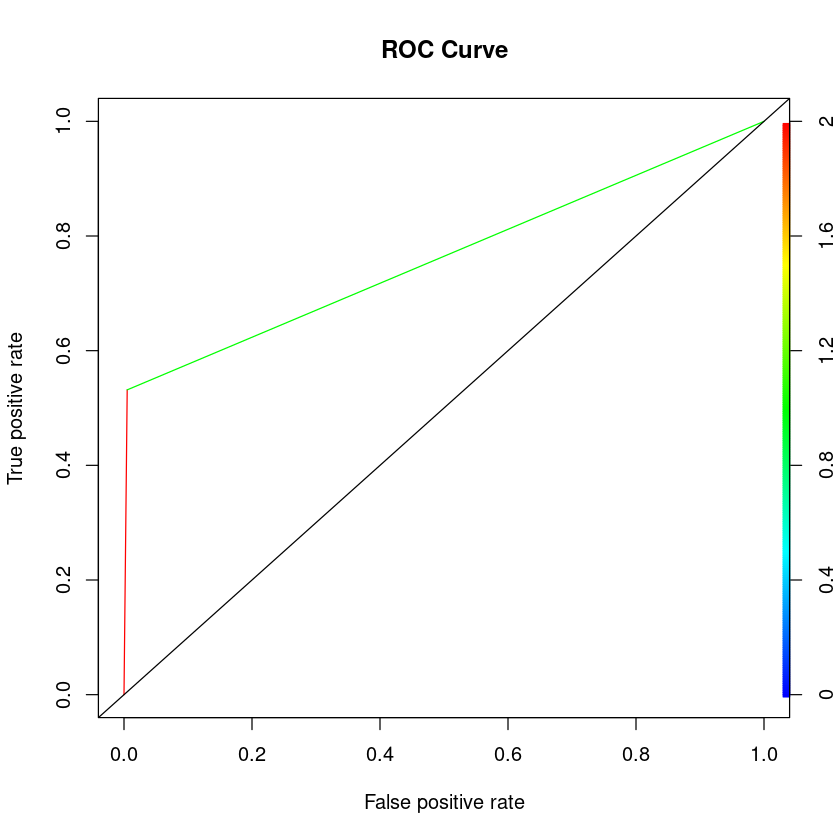

In [31]:
modelPerformance(k562rf1, "rf", test, Class)

The model performs well with the 70:30 data in terms of sensitivity and specificity; although for test data the model is marginally low on sensitivity. We see that the overall performance of the model on SMOTE data is descent, and we'll stick with this model.

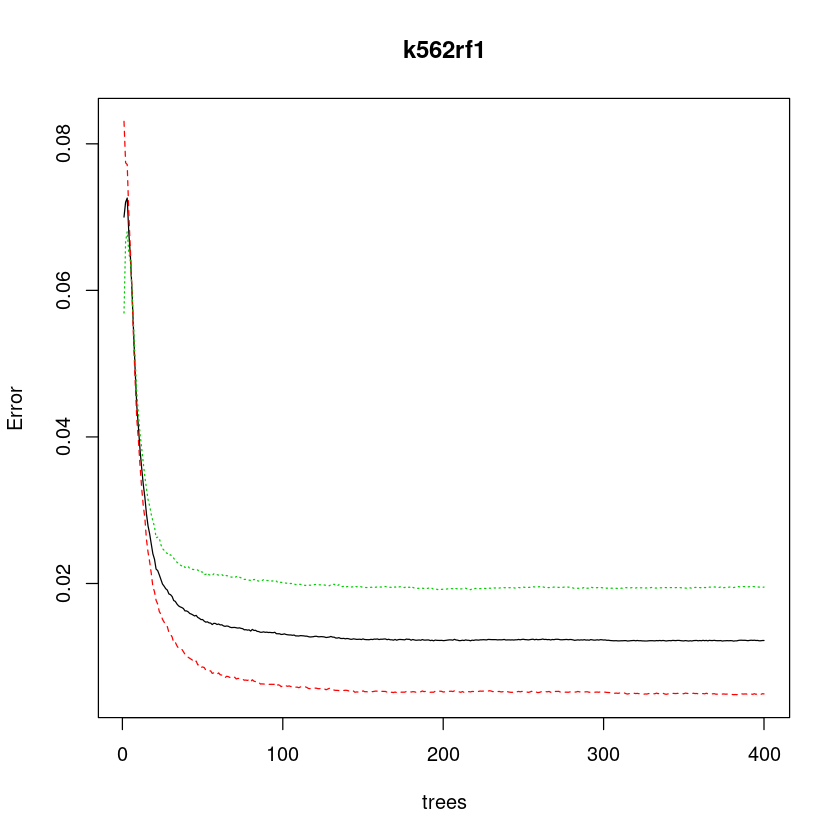

In [32]:
# Error rates (MSEs) of the Random Forest

plot(k562rf1)

The above plot shows that the error rate stablises after ~ 100 trees and any number of trees beyond doesn't bring any betterment to the error. In view of the same, we shall tune the paramaters of our forest to reduce the number of trees from 500 (default) to 100. Let us observe the change in results. This step helps ascertain an optimal value for *ntree*. 

In [33]:
head(bothTrain)

,CTCF,EP300,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H3K9me3,RAD21,RNA.Seq,RNAPol2,RNAPol3,YY1,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,0.2810432,0.3574208,0.28305251,0.08043035,0.62545046,0.13365366,0.2441023,0.3532478,1.087215,0.5064780,0.000000,0.08341947,0.3636749,0.15622630,0
2,0.3211923,0.4124086,0.08087214,0.12064553,0.11037361,0.08910244,0.2034186,0.1284538,1.970577,0.2251013,0.000000,0.13903244,0.1818374,0.31245260,0
3,1.0438749,0.6598537,0.84915752,0.72387316,0.51507685,0.49006343,0.4475208,0.8028360,0.000000,0.7878546,1.875639,3.44800460,0.4848998,1.71848927,0
4,0.3211923,0.9897806,0.88959359,0.84451868,0.51507685,0.22275610,0.5695720,0.3211344,0.000000,0.6190286,0.000000,0.27806489,1.1516371,0.78113149,0
5,0.1204471,0.7973232,0.20218036,0.36193658,0.07358241,0.17820488,0.4882045,0.2247941,0.000000,0.1125507,0.000000,0.13903244,0.3030624,0.31245260,0
6,0.2810432,0.3024330,0.16174429,0.20107588,0.11037361,0.13365366,0.1627348,0.2247941,1.257092,0.3939273,0.000000,0.05561298,0.4242873,0.07811315,0


mtry = 3  OOB error = 0% 
Searching left ...
mtry = 2 	OOB error = 0% 
0 0.005 
Searching right ...
mtry = 6 	OOB error = 0% 
-3 0.005 


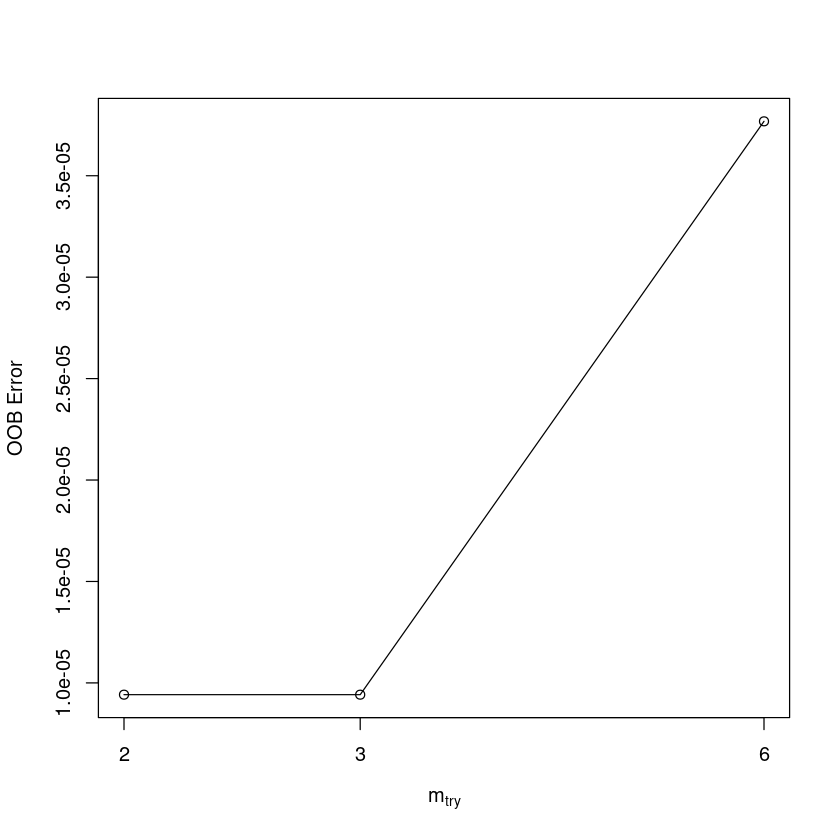

In [34]:
# Tuning mtry | stepfactor = 2

t2 <- tuneRF(bothTrain[,-15], bothTrain[,15],
            stepFactor = 2,
            plot = TRUE,
            ntreeTry = 100,
            trace = TRUE,
            improve = 0.005)               

mtry = 3  OOB error = 0% 
Searching left ...
mtry = 1 	OOB error = 0% 
-3 0.005 
Searching right ...
mtry = 14 	OOB error = 0.03% 
-29 0.005 


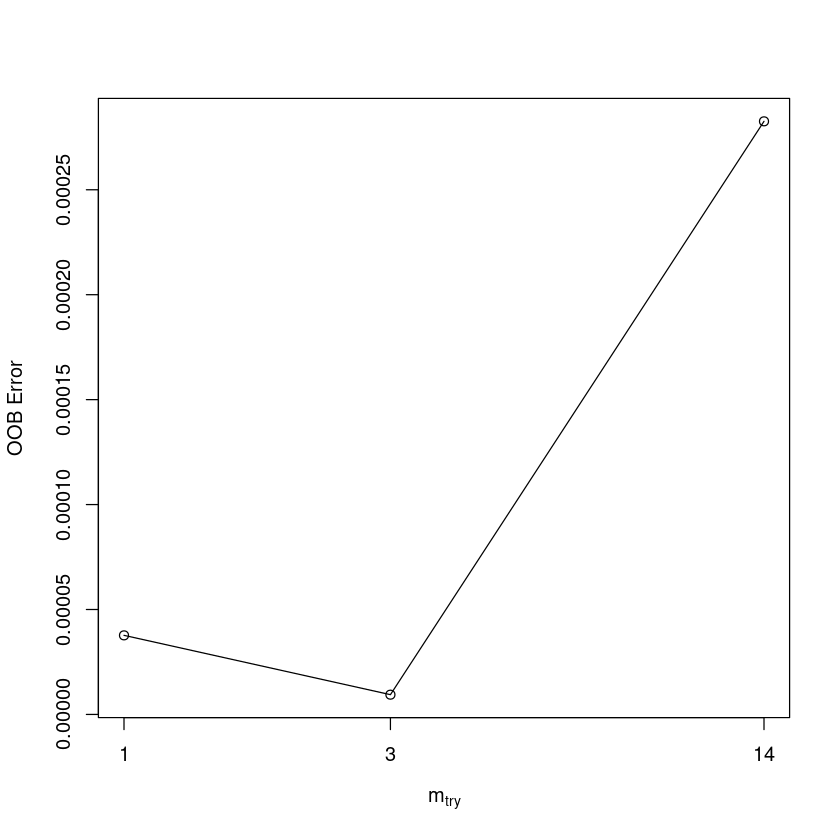

In [35]:
# Tuning mtry | stepfactor = 5

t3 <- tuneRF(bothTrain[,-15], bothTrain[,15],
            stepFactor = 5,
            plot = TRUE,
            ntreeTry = 100,
            trace = TRUE,
            improve = 0.005)   

mtry = 3  OOB error = 0% 
Searching left ...
mtry = 1 	OOB error = 0.02% 
-9.5 0.005 
Searching right ...
mtry = 12 	OOB error = 0.01% 
-6.5 0.005 


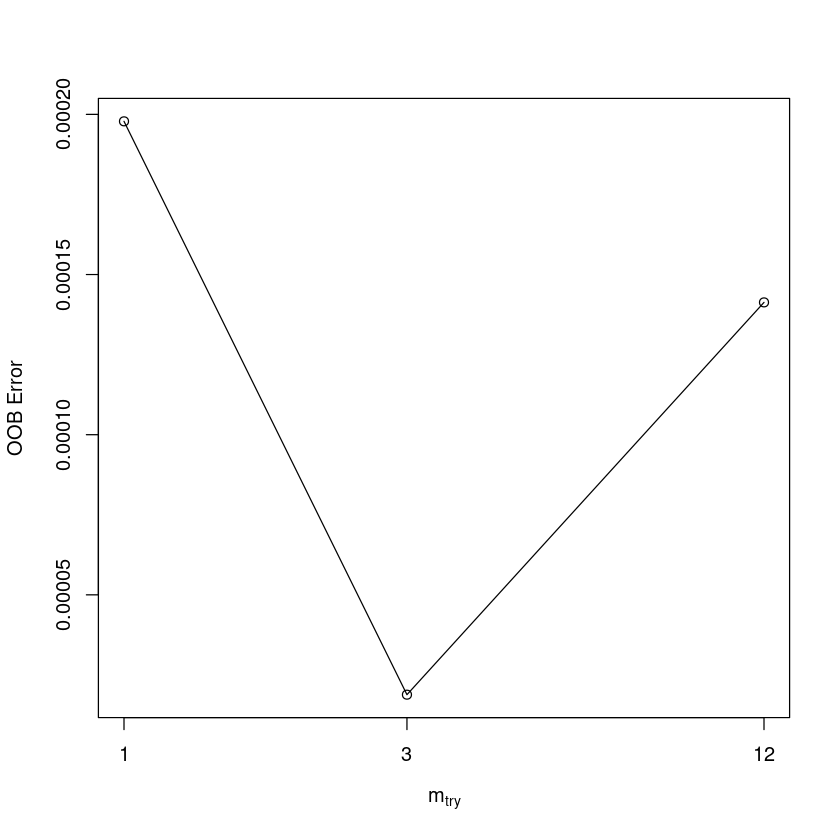

In [36]:
# Tuning mtry | stepfactor = 4

t4 <- tuneRF(bothTrain[,-15], bothTrain[,15],
            stepFactor = 4,
            plot = TRUE,
            ntreeTry = 100,
            trace = TRUE,
            improve = 0.005)   

mtry = 3  OOB error = 0% 
Searching left ...
mtry = 1 	OOB error = 0.01% 
-6 0.005 
Searching right ...
mtry = 9 	OOB error = 0.01% 
-2 0.005 


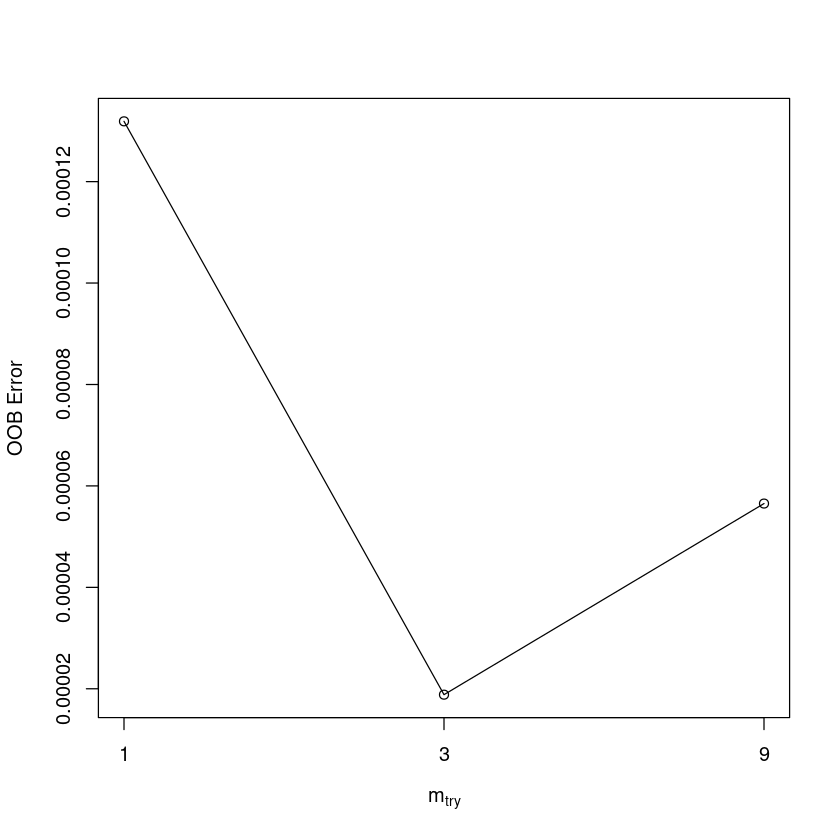

In [37]:
# Tuning mtry | stepfactor = 3

t5 <- tuneRF(bothTrain[,-15], bothTrain[,15],
            stepFactor = 3,
            plot = TRUE,
            ntreeTry = 100,
            trace = TRUE,
            improve = 0.005)   

I think we are good at *mtry* = 3; the error is minimum.

In [39]:
k562PredRFOpt <- predict(k562rf1,test73)
confusionMatrix(k562PredRFOpt, test73$Class, positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 45472    15
         1   217    94
                                          
               Accuracy : 0.9949          
                 95% CI : (0.9942, 0.9956)
    No Information Rate : 0.9976          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.4457          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.862385        
            Specificity : 0.995250        
         Pos Pred Value : 0.302251        
         Neg Pred Value : 0.999670        
             Prevalence : 0.002380        
         Detection Rate : 0.002052        
   Detection Prevalence : 0.006791        
      Balanced Accuracy : 0.928818        
                                          
       'Positive' Class : 1               
                  

The confusion matrix is
         Actual
Predicted     0     1
        0 45470    15
        1   219    94
The accuracy of the model is 99.48906 % 
The misclassification error of the model is 0.5109393 % 
The sensitivity of the model is 99.52067 % 
The specificity of the model is 86.23853 % 
The area under curve is 0.928796 



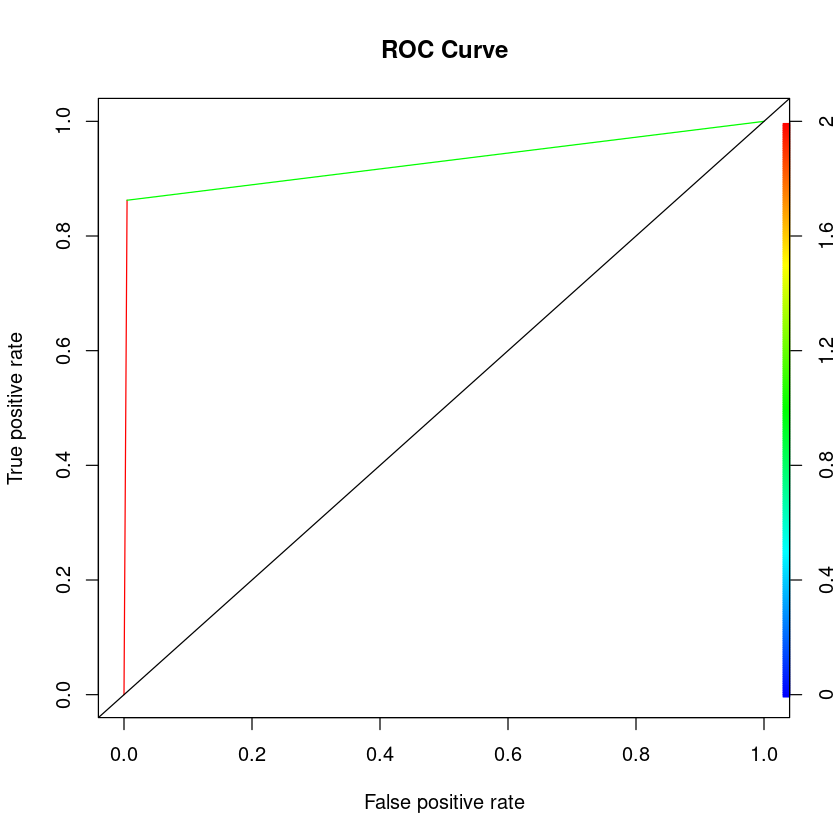

In [60]:
modelPerformance(k562rf1, "RF", test73, Class)

The confusion matrix is
         Actual
Predicted      0      1
        0 603301    355
        1   2952   1119
The accuracy of the model is 99.45584 % 
The misclassification error of the model is 0.5441588 % 
The sensitivity of the model is 99.51307 % 
The specificity of the model is 75.91588 % 
The area under curve is 0.8771447 



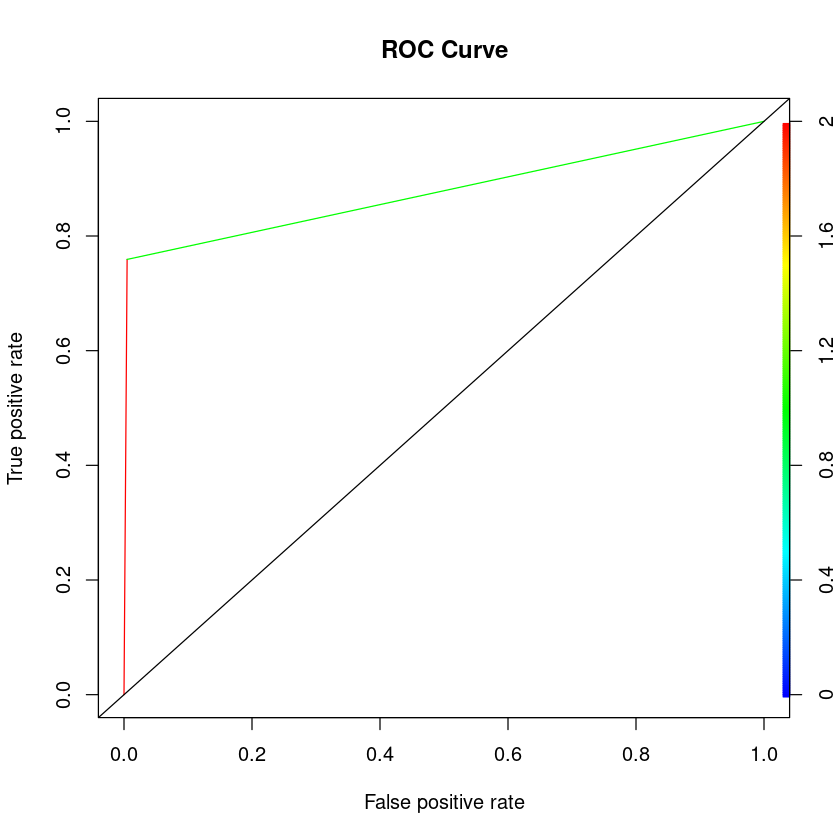

In [62]:
modelPerformance(k562rf1, "RF", test64, Class)

This model is performing well with the test73, test64 data as well. The metrics above (specifically, *accuracy*, *sensitivity*, and *specificity*) establish that the model accomodates the positive and negative classes really well.

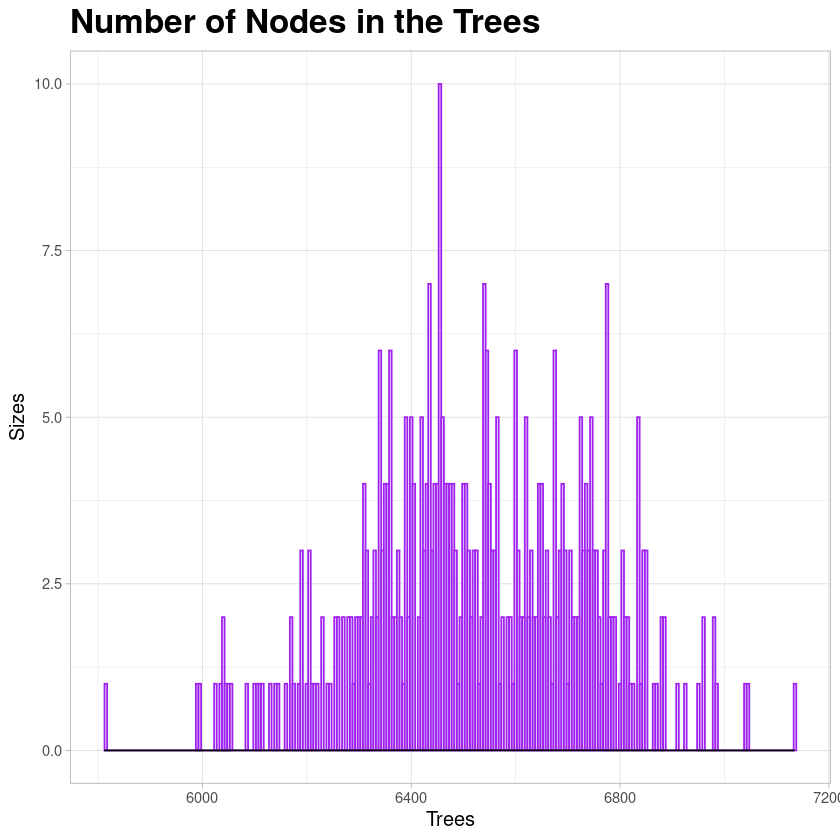

In [41]:
# Number of nodes for the trees

ts <- as.data.frame(treesize(k562rf1), row.names = c())
ggplot(data = ts, aes(x = `treesize(k562rf1)`)) + 
  geom_histogram(binwidth = 5, color="purple", fill="lavender", position="identity", alpha=0.7)+
  labs(x="Trees", y="Sizes")+
  ggtitle("Number of Nodes in the Trees")+
  geom_density(alpha=0.6)+
  theme_light()+
  theme(plot.title= element_text(size = 20, face = "bold"),
        axis.title = element_text(size = 12))

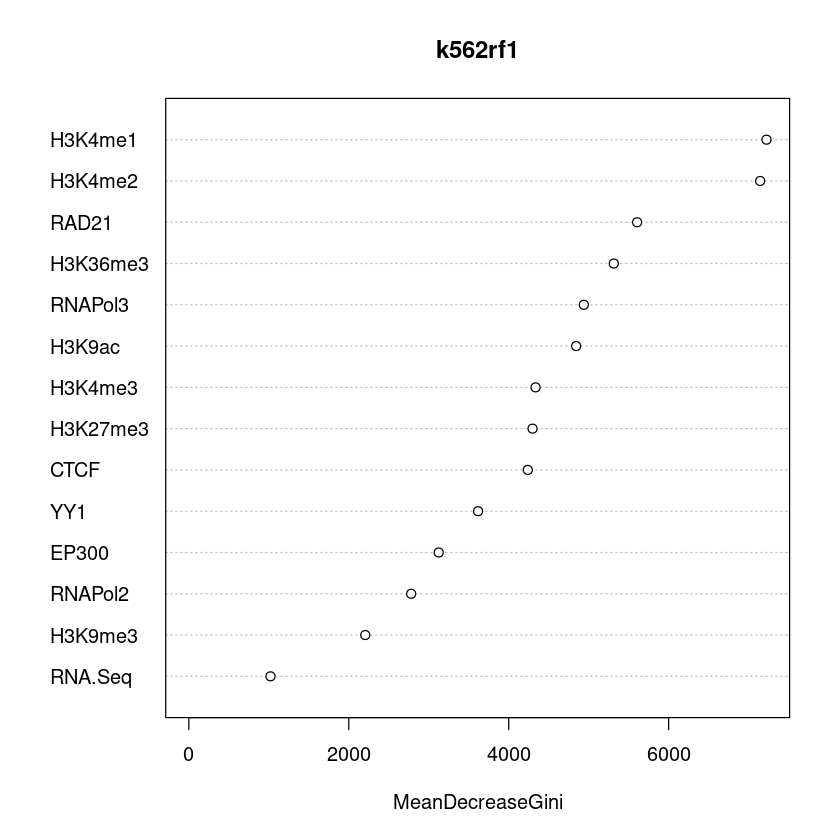

In [42]:
# Variable Importance

varImpPlot(k562rf1)

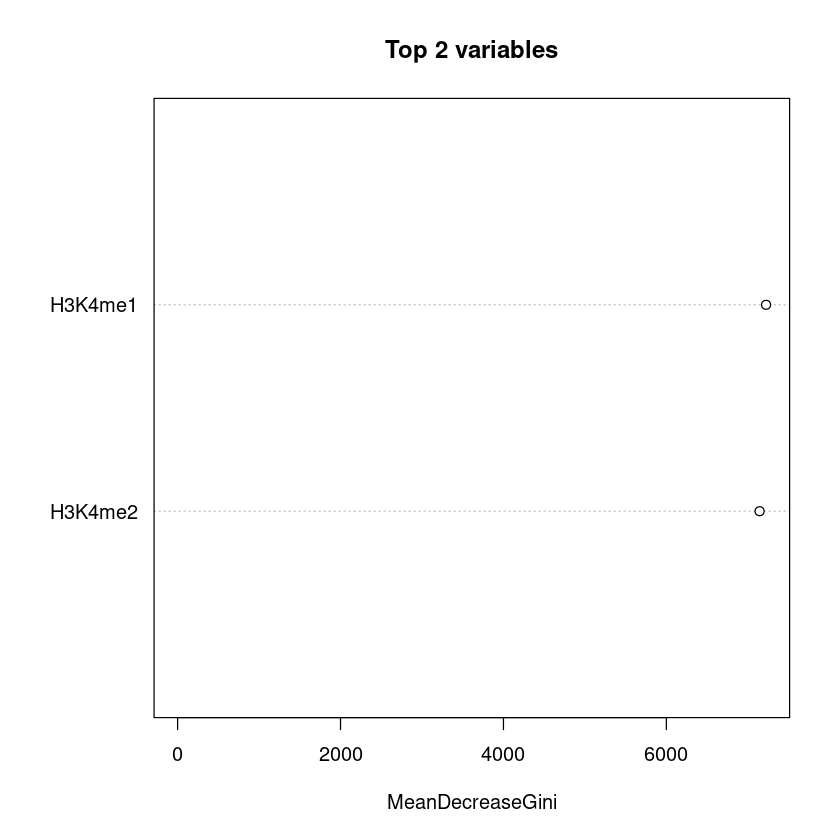

In [43]:
varImpPlot(k562rf1 , sort = TRUE, n.var = 2, main = "Top 2 variables")

In [44]:
importance(k562rf1)

,MeanDecreaseGini
CTCF,4238.899
EP300,3125.108
H3K27me3,4298.500
H3K36me3,5314.375
H3K4me1,7223.878
H3K4me2,7144.451
H3K4me3,4335.913
H3K9ac,4843.945
H3K9me3,2206.115
RAD21,5605.822


In [45]:
varUsed(k562rf1)

[1] 213767 187689 227663 218178 206203 197964 202746 202021 102806 210490
[11]  45710 175708 203736 215001

This classification model of random forests projects **H3K4me1** as the most crucial variable with maximum instances used while contruction of trees.

##  <a id=link10>3. Visualizing Predictions </a>

We choose to go with this model and will save the prediction results, that shall be later utilized for plotting.

In [46]:
k562gregModelPredictions <- predict(k562rf1, k562greg, type = "response")
k562gregModelPredictionsProbs <- as.factor(k562gregModelPredictions)

In [47]:
head(k562gregModelPredictionsProbs)

1 2 3 4 5 6 
0 0 0 0 0 0 
Levels: 0 1

Eventually, we have the original dataset with the classes and the one with the model predictions. We attempt to map the prediction results corresponding to LR-Hubs from the K562 cell-line. It will be interesting to see the intersect of the pre-caliberated LR-Hubs and the ones predicted by the classifier.

<a href = "http://www.bioconductor.org/packages/release/bioc/html/Gviz.html" > Gviz</a> is the package we aim to deploy for visualization.

In [48]:
if(!requireNamespace("BiocManager", quietly = TRUE))
BiocManager::install("Gviz")
suppressPackageStartupMessages(library(Gviz))

Next, we recall the data from the K562 cell-line (GREG). We already know, this is a comprehensive data (genome-wide) with values corresponding to epigenetic marks (features) for each bin (a 2Kb genomic region), in addition to a "Class", i.e. a "Hub" or a "Non-Hub". For the present case, we shall prune the data for the genomic intervals and their corresponding class. That is all we need! 

In [49]:
k562gregStandardRegionsClass <- k562gregStandard[, c(1:3,18)]

Also, considering the computational resources we deploy, we shall focus on chromosome 21 only.

In [50]:
head(k562gregStandardRegionsClass)

,chr,start,end,Class
,<fct>,<int>,<int>,<fct>
1,chr1,1,2000,Non-Hub
2,chr1,2001,4000,Non-Hub
3,chr1,4001,6000,Non-Hub
4,chr1,6001,8000,Non-Hub
5,chr1,8001,10000,Non-Hub
6,chr1,10001,12000,Non-Hub


In [51]:
## Extracting chr21 data

k562gregChr21NonHub <- k562gregStandardRegionsClass[k562gregStandardRegionsClass$chr=="chr21" & k562gregStandardRegionsClass$Class=="Non-Hub", ] ## subset of data for exemplifying
k562gregChr21Hub <- k562gregStandardRegionsClass[k562gregStandardRegionsClass$chr=="chr21" & k562gregStandardRegionsClass$Class=="Hub", ]

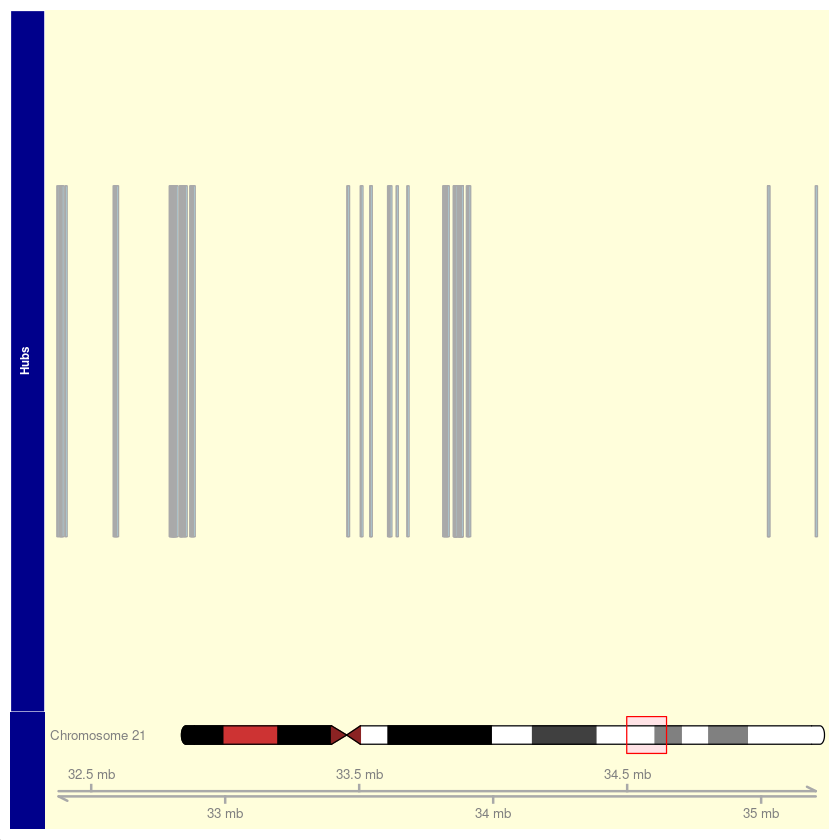

In [52]:
# Plotting Hubs

annotationTrackHub <- AnnotationTrack(range = k562gregChr21Hub, 
                                      name = "Hubs", 
                                      genome = "hg38", 
                                      chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
genomeTrack <- GenomeAxisTrack()
plotTracks(list(annotationTrackHub, itrack, genomeTrack), 
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

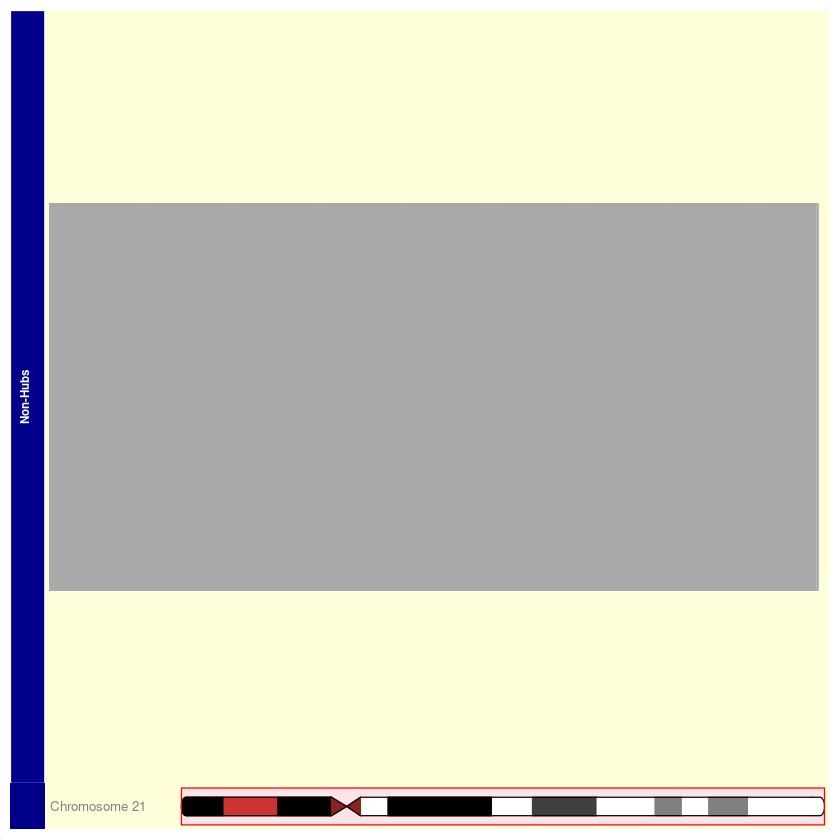

In [53]:
# Plotting Non-Hubs

annotationTrackNonHub <- AnnotationTrack(range = k562gregChr21NonHub, 
                                         name = "Non-Hubs", 
                                         genome = "hg38", 
                                         chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
plotTracks(list(annotationTrackNonHub, itrack),
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

We can observe that the Non-Hubs are pretty evenly distributed throughout the chromosome.In contrast, we are curious to examine if the findings of the classifier are able to fortify the original class definitions. Let us frame the data from the predicted results. 

In [54]:
k562gregPredicted <- cbind(k562gregStandardRegionsClass, k562gregModelPredictionsProbs)
names(k562gregPredicted)[names(k562gregPredicted) == "k562gregModelPredictionsProbs"] <- "Prediction"
k562gregPredicted$Prediction <- ifelse(k562gregPredicted$Prediction == 1, "Hub", "Non-Hub")  

Let us see if the classifier predictions match with the original results.

In [55]:
k562gregChr21PredicitedHub <- k562gregPredicted[k562gregPredicted$chr=="chr21" & k562gregPredicted$Prediction =="Hub", ]

Certainly, the predicted hubs are far more in number and there are noticeable instances of "Non-Hubs" that have been classified as "Hubs", with the given profile of the classification model.  

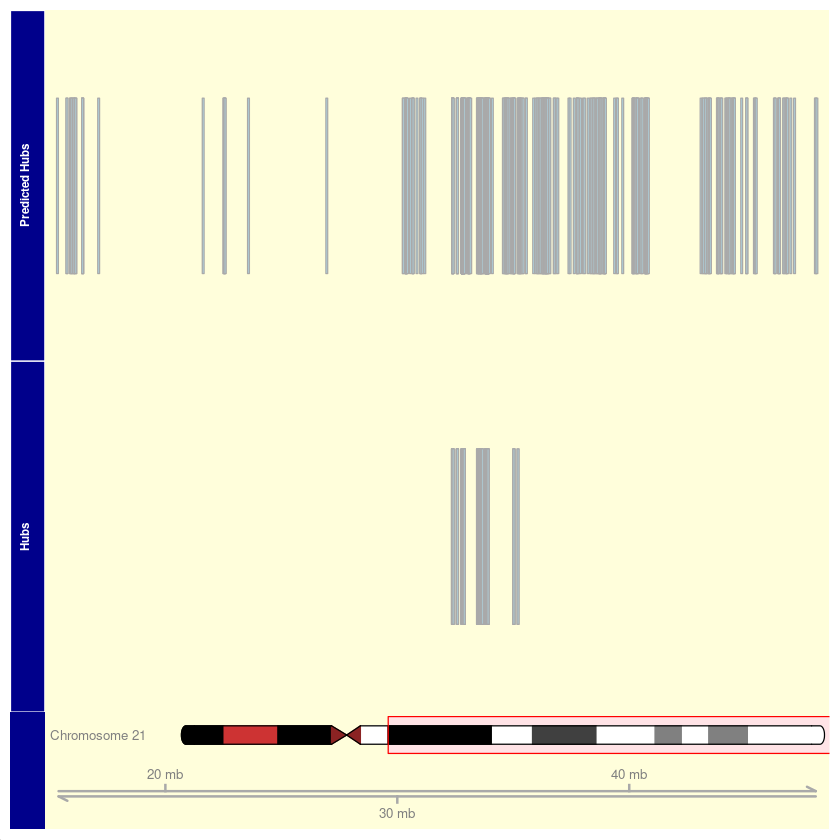

In [56]:
# Plotting Predicted Hubs
annotationTrackHub <- AnnotationTrack(range = k562gregChr21Hub, 
                                      name = "Hubs", 
                                      genome = "hg38", 
                                      chromosome = "chr21")
annotationTrackPredictedHub <- AnnotationTrack(range = k562gregChr21PredicitedHub, 
                                               name = "Predicted Hubs", 
                                               genome = "hg38", 
                                               chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
genomeTrack <- GenomeAxisTrack()
plotTracks(list(annotationTrackPredictedHub,annotationTrackHub, itrack, genomeTrack), 
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

In [57]:
truePositives <- k562gregPredicted[k562gregPredicted$Class == k562gregPredicted$Prediction, ]

As we close, we'll save the optimal model and true positive genomic regions (hubs) as explicit R data objects, in order to recall for later use.

In [61]:
## Saving relevant files

save(k562rf1, file = "./optimalModels/k562modelRF") # optimal model
write.table(truePositives, file = "./truePositives/k562RF.txt", quote = FALSE) # true positives: precicted ~ original
write.table(smoteData, file = "./buildData/optimalModelTrainK562RF.txt", quote = FALSE) # data used to train model
write.table(test73, file = "./buildData/optimalModelTestK562RF.txt", quote = FALSE) # data used to test model

## Conclusion

We see that the best performing model isn't just graded by its accuracy (which is corresponding to the current state of class distribution), but by how well it is able to differentiate between the negative and positive classes. Considering the same as premise, we identified that the following is the best performing model with related attributes.

| Best Model | Accuracy | Sensitivity | Specificity | Remark
| --- | --- | --- | --- | ---
| k562rf1 | 99.48906 % | 99.52067 % | 86.23853 % | Excellent

Despite having a slightly higher sensitivity, i.e. higher knack for predicting positive classes, the model's performance could be considered exceptional, inspite of remarkable accuracy. In addition, we observe that the model has a high specificity. This symbolises that the negative classes are also marked considerably well.   

##  <a id=link11>4. Session Information </a>

In [45]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] parallel  stats4    grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] Gviz_1.30.3          GenomicRanges_1.38.0 GenomeInfoDb_1.22.1 
 [4] IRanges_2.20.2       S4Vectors_0.24.4     BiocGenerics_0.32.0 
 [7] ROCR_1.0-11          caret_6.0-86         ggplot2_3.3.2       
[10] e1071_1.7-3          ROSE_0.0-3           randomForest_4.6-14 
[13] DMwR_0.4.1           l